# Prior estimation with Baseball Data
Comparison of the Empirical Reference Prior (ERP) to the James-Stein and MLE estimators
with the Efron Baseball dataset.

In [18]:
using Revise
using ObjectiveEmpiricalBayes
import ObjectiveEmpiricalBayes: OptConfig, Transformation, FEModel, generatedata, transformmodel, 
    ReferenceRegularizer, ThikonovRegularizer, cvscore, ebprior, compareplot, likelihoodmat, cvreference

using Random: seed!
using Distributions
using PyPlot
using CSV
using LinearAlgebra
linspace(x...) = LinRange(x...) |> collect
midpoints(min, max, n) = [min + (max-min) / n * (i-1/2) for i=1:n]

OPTCONFIG=OptConfig(XTOLABS=1e-8, MAXEVAL=10000);

In [19]:
table = CSV.read("baseballdata.csv")

,FirstName,LastName,At-Bats,Hits,BattingAverage,RemainingAt-Bats,RemainingHits
,String,String,Int64,Int64,Float64,Int64,Int64
1,Roberto,Clemente,45,18,0.4,367,127
2,Frank,Robinson,45,17,0.378,426,127
3,Frank,Howard,45,16,0.356,521,144
4,Jay,Johnstone,45,15,0.333,275,61
5,Ken,Berry,45,14,0.311,418,114
6,Jim,Spencer,45,14,0.311,466,126
7,Don,Kessinger,45,13,0.289,586,155
8,Luis,Alvarado,45,12,0.267,138,29
9,Ron,Santo,45,11,0.244,510,137


In [20]:
xs = midpoints(0.1, 0.5, 300)

data = table[:,:BattingAverage]
M = length(data)
N = 45
σ = sqrt(mean(data) * (1 - mean(data)) / N)

0.06582090626055082

In [21]:
function cverp(m, data)
    gamma, opt = cvreference(m, data, 0, 1, rel_tol = 1e-3, show_trace=false, c=OPTCONFIG)
    wi = ebprior(m,  data, ReferenceRegularizer(m,  gamma), OPTCONFIG)
    wi, gamma
end

cverp (generic function with 1 method)

In [22]:
B = 1 - (M - 3) * σ^2 / sum((data .- mean(data)).^2)
μ_js = mean(data)
σ_js = sqrt(B * σ^2 / (1 - B))

w_js = normalize(pdf.(Normal(μ_js, σ_js), xs), 1);

In [23]:
m = FEModel(f=x->x, xs=xs, σ=σ)

@time w_er, reg = cverp(m, data)

  2.273862 seconds (2.34 M allocations: 3.510 GiB, 10.17% gc time)


([3.399112865628384e-10, 4.126577700242253e-10, 5.022944805967322e-10, 6.129837339847122e-10, 7.49960406297248e-10, 9.19818627775124e-10, 1.1308746644026832e-9, 1.3936310212213037e-9, 1.721366676403731e-9, 2.130890718881522e-9  …  3.107289758182785e-11, 2.662674561411604e-11, 2.2888283491596435e-11, 1.9735100355725804e-11, 1.707137834928036e-11, 1.481519553020638e-11, 1.2884835562208557e-11, 1.1235908136614174e-11, 9.83341498479359e-12, 8.64558012168367e-12], 0.04082616405062899)

In [24]:
# TODO: Binomial Model

m_bin = ObjectiveEmpiricalBayes.BinomialModel(N, xs)
reg_bin = 0

data_bin = round.(Int, data * N)
w_bin, reg = cverp(m_bin, data_bin)

#figure()
#plot(xs, w_bin)

([1.3965701009288427e-12, 1.55270942416253e-12, 1.7458530284201895e-12, 1.988865820579785e-12, 2.3005988628028804e-12, 2.709350965082302e-12, 3.2586322313664427e-12, 4.016750956203769e-12, 5.092232525693184e-12, 6.655905643753655e-12  …  2.6407167794962544e-12, 2.3743518558902236e-12, 2.151947069452449e-12, 1.964385453417675e-12, 1.8047459982603286e-12, 1.6677175649568867e-12, 1.5491806035850424e-12, 1.4459065113152526e-12, 1.3553396838075027e-12, 1.275438031909653e-12], 0.033815679623135975)

In [25]:
L=likelihoodmat(m, data)
function posteriors(w)
    post = w .* L'
    post = post ./ sum(post, dims=1)
end

posteriormeans(w) = posteriors(w)' * xs

truth = table[:, :RemainingHits] ./ table[:, Symbol("RemainingAt-Bats")]

function errors(w)
    posteriormeans(w) - truth
end

mse(w) = mean(x->x^2, errors(w))

mse (generic function with 1 method)

In [26]:
# compute the individual posteriors
posts = hcat((posteriormeans(w) for w in [w_js, w_er, w_bin])...)

18×3 Array{Float64,2}:
 0.293979  0.303505  0.298452
 0.289306  0.296439  0.292578
 0.284634  0.289381  0.286688
 0.279749  0.282186  0.280615
 0.275076  0.275622  0.274981
 0.275076  0.275622  0.274981
 0.270404  0.269469  0.269594
 0.265731  0.263779  0.264506
 0.260846  0.258339  0.259539
 0.260846  0.258339  0.259539
 0.256174  0.253602  0.255135
 0.256174  0.253602  0.255135
 0.256174  0.253602  0.255135
 0.256174  0.253602  0.255135
 0.256174  0.253602  0.255135
 0.251501  0.249282  0.251062
 0.246828  0.24533   0.247301
 0.242156  0.241695  0.243827

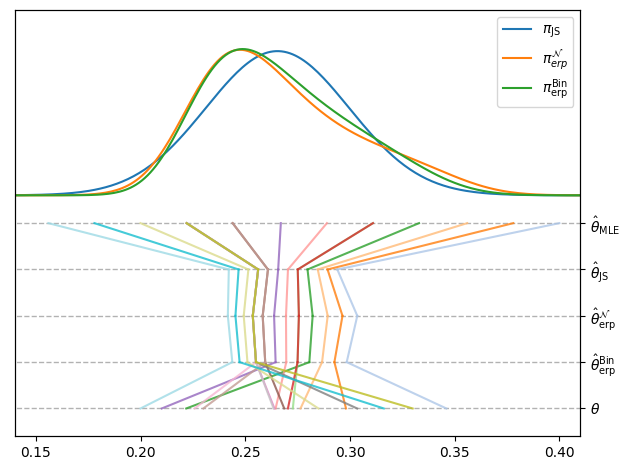

In [27]:
fig, ax1 = subplots()

xmin, xmax = .14, .41
ymin, ymax = -0.026, 0.02

plot(xs, w_js, label="\$\\pi_{\\rm JS}\$")
plot(xs, w_er, label="\$\\pi^{\\mathcal{N}}_{erp}\$")
plot(xs, w_bin, label="\$\\pi^{\\rmBin}_{\\rmerp}\$")
legend()

#grid(which="major",axis="both", alpha=0.2)

xlim(xmin, xmax)
ylim(ymin, ymax)
ax1.set_yticks([])

#subplot(212, sharex=ax1)
offset = -0.003
scale=-5e-3

dots = hcat(data, posts, truth)
scale = scale=-5e-3

yt = vcat([0,1,2,3,4] .* scale.+offset)
ytl = vcat(["\$\\hat\\theta_{\\rmMLE}\$",
        "\$\\hat\\theta_{\\rmJS}\$", 
        "\$\\hat\\theta_{\\rmerp}^{\\mathcal{N}}\$", 
        "\$\\hat\\theta_{\\rmerp}^{\\rmBin}\$", 
        "\$\\theta\$"])

ax2 = ax1.twinx()
#ax2.yaxis.set_label_position("right")


ax2.set_ylim(ymin , ymax)
ax2.set_yticks(yt)
ax2.set_yticklabels(ytl)

ax2.hlines([0,1,2,3,4] .* scale.+offset, 0, 1, linewidth=1, alpha=0.3, linestyle="dashed")

for i=1:size(dots, 1)
    for j=1:size(dots, 2)-1
        ax2.plot([dots[i,j], dots[i,j+1]], [j-1,j].*scale.+offset, alpha=0.8, c=PyPlot.cm.tab20(i/18))
    end
end
fig.tight_layout()
savefig("plots/baseball.pdf", bbox_inches="tight")

In [28]:
# compute mean squared errors
mse_ml = mean(x->x^2, data - truth)
@show mse_ml
@show mse(w_js) / mse_ml
@show mse(w_er) / mse_ml
@show mse(w_bin) / mse_ml

mse_ml = 0.004764985095190408
mse(w_js) / mse_ml = 0.31242256652523565
mse(w_er) / mse_ml = 0.31238455204949256
mse(w_bin) / mse_ml = 0.30982846944781234


0.30982846944781234

In [29]:
# compute mean squared errors
mse_ml = mean(x->x^2, data - truth)
@show mse_ml
@show mse(w_js) / mse_ml
@show mse(w_er) / mse_ml
@show mse(w_bin) / mse_ml

mse_ml = 0.004764985095190408
mse(w_js) / mse_ml = 0.31242256652523565
mse(w_er) / mse_ml = 0.31238455204949256
mse(w_bin) / mse_ml = 0.30982846944781234


0.30982846944781234

In [30]:
# print results in latex table
using Printf
spf(x) = Printf.@sprintf("%.3f", x)

function latex_table()
    digits = 3
    let posts = round.(posts, digits=digits), 
        data = round.(data, digits=digits),
        truth = round.(truth, digits=digits)
    for i=1:18
        if i%2 == 1
            println("\\rowcolor{black!20}")
            end
        println("$(table[i,2]) & " *
            "\$$(spf(data[i])) = \\nicefrac{$(table[i,4])}{45}\$ & " *
            "\$$(spf(posts[i,1])) \$& \$$(spf(posts[i,2]))\$ & \$$(spf(posts[i,3]))\$ & " *
            "\$$(spf(truth[i])) = \\nicefrac{$(table[i,7])}{$(table[i,6])} \$ " *
            "\\\\"
            )
    end
    end
end
latex_table()

\rowcolor{black!20}
Clemente & $0.400 = \nicefrac{18}{45}$ & $0.294 $& $0.304$ & $0.298$ & $0.346 = \nicefrac{127}{367} $ \\
Robinson & $0.378 = \nicefrac{17}{45}$ & $0.289 $& $0.296$ & $0.293$ & $0.298 = \nicefrac{127}{426} $ \\
\rowcolor{black!20}
Howard & $0.356 = \nicefrac{16}{45}$ & $0.285 $& $0.289$ & $0.287$ & $0.276 = \nicefrac{144}{521} $ \\
Johnstone & $0.333 = \nicefrac{15}{45}$ & $0.280 $& $0.282$ & $0.281$ & $0.222 = \nicefrac{61}{275} $ \\
\rowcolor{black!20}
Berry & $0.311 = \nicefrac{14}{45}$ & $0.275 $& $0.276$ & $0.275$ & $0.273 = \nicefrac{114}{418} $ \\
Spencer & $0.311 = \nicefrac{14}{45}$ & $0.275 $& $0.276$ & $0.275$ & $0.270 = \nicefrac{126}{466} $ \\
\rowcolor{black!20}
Kessinger & $0.289 = \nicefrac{13}{45}$ & $0.270 $& $0.269$ & $0.270$ & $0.265 = \nicefrac{155}{586} $ \\
Alvarado & $0.267 = \nicefrac{12}{45}$ & $0.266 $& $0.264$ & $0.265$ & $0.210 = \nicefrac{29}{138} $ \\
\rowcolor{black!20}
Santo & $0.244 = \nicefrac{11}{45}$ & $0.261 $& $0.258$ & $0.260$ 

## Comparison of true leave-1-out estimation vs whole data

  4.500248 seconds (4.97 M allocations: 7.644 GiB, 10.42% gc time)
(i, maximum(wi), gamma) = (1, 0.6104462115206177, 5.169601896241058e-6)
  2.766540 seconds (3.03 M allocations: 4.801 GiB, 10.41% gc time)
(i, maximum(wi), gamma) = (2, 0.02832768634330716, 0.012035483168134515)
  1.934537 seconds (2.12 M allocations: 3.299 GiB, 10.27% gc time)
(i, maximum(wi), gamma) = (3, 0.01762608244335858, 0.041279267904413816)
  1.842019 seconds (2.01 M allocations: 3.122 GiB, 10.32% gc time)
(i, maximum(wi), gamma) = (4, 0.015635517814305312, 0.05244939971398713)
  1.706604 seconds (1.96 M allocations: 3.049 GiB, 10.38% gc time)
(i, maximum(wi), gamma) = (5, 0.014624999580595446, 0.05652733439805053)
  1.704572 seconds (1.96 M allocations: 3.049 GiB, 10.56% gc time)
(i, maximum(wi), gamma) = (6, 0.014624999580595446, 0.05652733439805053)
  1.622968 seconds (1.90 M allocations: 2.957 GiB, 10.50% gc time)
(i, maximum(wi), gamma) = (7, 0.013907227514409023, 0.057647468726340856)
  1.634019 seconds (

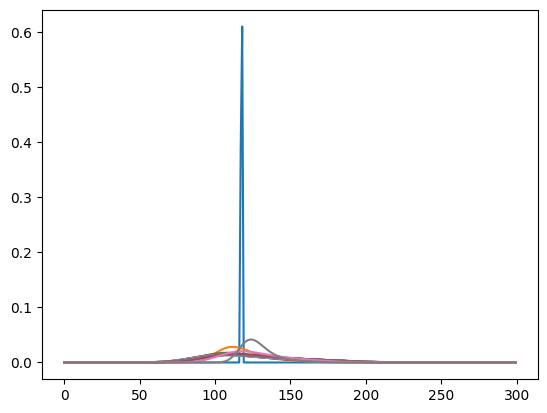

  3.451951 seconds (3.79 M allocations: 6.034 GiB, 10.34% gc time)
(i, maximum(wi), gamma) = (18, 0.041734603969951455, 0.004021472598389957)
 37.769947 seconds (42.33 M allocations: 65.963 GiB, 10.38% gc time)
mse_loo_n / mse_ml = 0.3945626344599706


0-element Array{Any,1}

In [31]:
wis_n = []
@time for i = 1:18
    data_loo = deleteat!(copy(data), i)

    σ = sqrt(mean(data_loo) * (1 - mean(data_loo)) / N)
    m = FEModel(f=x->x, xs=xs, σ=σ)
    
    @time wi, gamma = cverp(m, data_loo)
    @show i, maximum(wi), gamma
    push!(wis_n, wi)
    plot(wi)
end

loo_n = [posteriormeans(wis_n[i])[i] for i=1:18]
mse_loo_n = mean(x->x^2, loo_n - truth)
@show mse_loo_n / mse_ml;

plot()

  4.335150 seconds (4.49 M allocations: 7.429 GiB, 10.46% gc time)
(i, maximum(wi), gamma) = (1, 0.6174921335222263, 1.1589534575557366e-5)
 13.938331 seconds (12.24 M allocations: 20.307 GiB, 10.56% gc time)
(i, maximum(wi), gamma) = (2, 0.14238889423741224, 0.00017253278121238404)
  2.229957 seconds (2.20 M allocations: 3.618 GiB, 10.01% gc time)
(i, maximum(wi), gamma) = (3, 0.018708504051445182, 0.029976922172136714)
  2.312763 seconds (2.02 M allocations: 3.332 GiB, 9.80% gc time)
(i, maximum(wi), gamma) = (4, 0.015847405886778843, 0.04403874737613119)
  1.784519 seconds (1.96 M allocations: 3.227 GiB, 10.56% gc time)
(i, maximum(wi), gamma) = (5, 0.014595438781335873, 0.049475993621549065)
  1.805627 seconds (1.96 M allocations: 3.227 GiB, 10.44% gc time)
(i, maximum(wi), gamma) = (6, 0.014595438781335873, 0.049475993621549065)
  1.748453 seconds (1.91 M allocations: 3.147 GiB, 10.29% gc time)
(i, maximum(wi), gamma) = (7, 0.013725509207597542, 0.05171626227812972)
  1.734067 sec

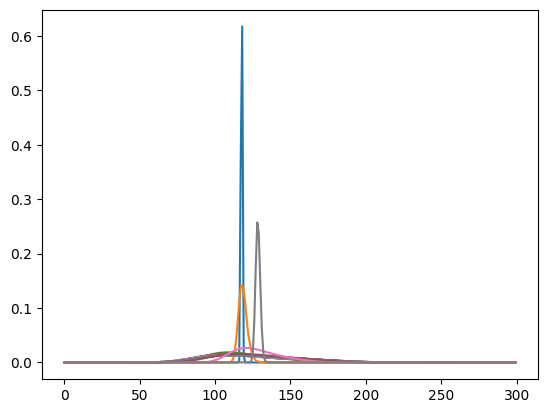

  8.999451 seconds (9.58 M allocations: 15.889 GiB, 10.30% gc time)
(i, maximum(wi), gamma) = (18, 0.25738175990156553, 6.469979295464403e-5)
 58.739179 seconds (57.33 M allocations: 94.680 GiB, 10.23% gc time)
mse_loo_bin / mse_ml = 0.39982874666717594


0-element Array{Any,1}

In [32]:
wis_bin = []
@time for i = 1:18
    data_loo = deleteat!(copy(round.(Int, data * N)), i)

    m = m_bin
    
    @time wi, gamma = cverp(m, data_loo)
    @show i, maximum(wi), gamma
    push!(wis_bin, wi)
    plot(wi)
end

loo_bin = [posteriormeans(wis_bin[i])[i] for i=1:18]
mse_loo_bin = mean(x->x^2, loo_bin - truth)
@show mse_loo_bin / mse_ml;

plot()

In [33]:
dots2 = hcat(dots, loo_n, loo_bin)

18×7 Array{Float64,2}:
 0.4    0.293979  0.303505  0.298452  0.346049  0.257495  0.257535
 0.378  0.289306  0.296439  0.292578  0.298122  0.274591  0.259733
 0.356  0.284634  0.289381  0.286688  0.276392  0.28474   0.280326
 0.333  0.279749  0.282186  0.280615  0.221818  0.281662  0.279746
 0.311  0.275076  0.275622  0.274981  0.272727  0.275721  0.275182
 0.311  0.275076  0.275622  0.274981  0.270386  0.275721  0.275182
 0.289  0.270404  0.269469  0.269594  0.264505  0.269243  0.269551
 0.267  0.265731  0.263779  0.264506  0.210145  0.263195  0.263968
 0.244  0.260846  0.258339  0.259539  0.268627  0.257941  0.258891
 0.244  0.260846  0.258339  0.259539  0.23      0.257941  0.258891
 0.222  0.256174  0.253602  0.255135  0.263941  0.254495  0.25564 
 0.222  0.256174  0.253602  0.255135  0.225806  0.254495  0.25564 
 0.222  0.256174  0.253602  0.255135  0.303448  0.254495  0.25564 
 0.222  0.256174  0.253602  0.255135  0.263538  0.254495  0.25564 
 0.222  0.256174  0.253602  0.255135  0

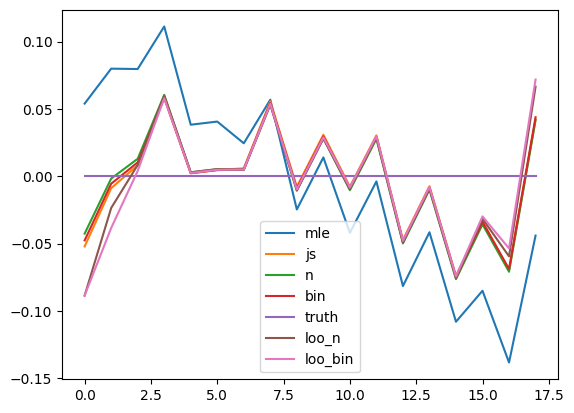

PyObject <matplotlib.legend.Legend object at 0x7f13d3454e10>

In [34]:
plot(dots2.-truth)
legend(["mle","js", "n", "bin", "truth", "loo_n", "loo_bin"])